In [1]:
from utils import train_utils, data_utils, anchor_utils, bbox_utils
import tensorflow as tf
from config import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model, _, _, _ = train_utils.get_model()

Model: YOLOv4


In [5]:
dataloader = data_utils.DataLoader(batch_size=BATCH_SIZE)
test_dataset = dataloader('train', use_label=True)

/home/hs/anaconda3/envs/tf28/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: custom train
./data/custom/train.tfrecord is exist


In [6]:
data = next(iter(test_dataset))

In [7]:
images, s_grids, m_grids, l_grids, labels = data

0 0 3 1


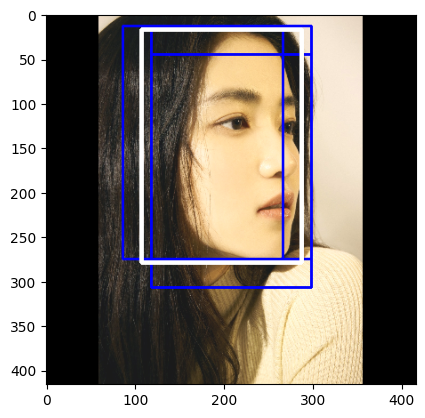

In [8]:
for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images.numpy()*255, s_grids, m_grids, l_grids, labels)):
    if i==0:
        image = image.astype(np.int32)

        s_grid = np.reshape(s_grid, [-1, 11])
        m_grid = np.reshape(m_grid, [-1, 11])
        l_grid = np.reshape(l_grid, [-1, 11])

        ss = 0 
        for s in s_grid:
            if s[4] != 0:
                p1 = (s[..., :2] - 0.5 * s[..., 2:4]).astype(np.int32)
                p2 = (s[..., :2] + 0.5 * s[..., 2:4]).astype(np.int32)
                cv2.rectangle(image, p1, p2, (255, 0, 0), 2)
                ss += 1

        mm = 0
        for m in m_grid:
            if m[4] != 0:
                p1 = (m[..., :2] - 0.5 * m[..., 2:4]).astype(np.int32)
                p2 = (m[..., :2] + 0.5 * m[..., 2:4]).astype(np.int32)
                cv2.rectangle(image, p1, p2, (0, 255, 0), 2)
                mm += 1

        ll = 0
        for l in l_grid:
            if l[4] != 0:
                p1 = (l[..., :2] - 0.5 * l[..., 2:4]).astype(np.int32)
                p2 = (l[..., :2] + 0.5 * l[..., 2:4]).astype(np.int32)
                cv2.rectangle(image, p1, p2, (0, 0, 255), 2)
                ll += 1

        gg = 0
        for g in label.numpy():
            if g[4] != 0:
                p1 = (g[..., :2] - 0.5 * g[..., 2:4]).astype(np.int32)
                p2 = (g[..., :2] + 0.5 * g[..., 2:4]).astype(np.int32)
                cv2.rectangle(image, p1, p2, (255, 255, 255), 3)
                gg += 1
        plt.imshow(image)
        print(ss, mm, ll, gg)
plt.show()

In [9]:
out = model(images[0:1])

In [11]:
anchors = anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)

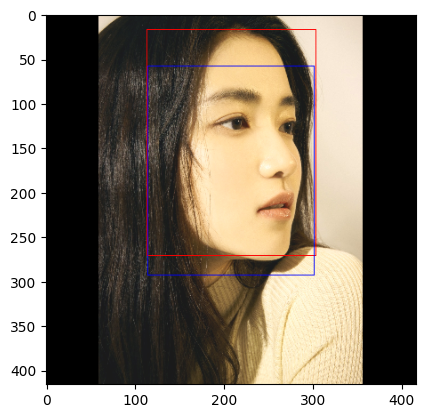

In [17]:
for g, anchor, stride in zip(out, anchors, STRIDES):
    i = (images[0].numpy()*255).astype(np.uint8)
    bbox = g[..., :4]
    conf = g[..., 4:5]
    prob = g[..., 5:]
    pred_xy = tf.sigmoid(bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride

    best_c = 0.
    best_box = [[0,0],[0,0]]
    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), conf.numpy().reshape(-1, 1), prob.numpy().reshape(-1, 1)):
        
        if c>0.06:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)
            if best_c < c:
                best_c = c
                best_box = [p1, p2]

    cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)


plt.imshow(i)
plt.show()

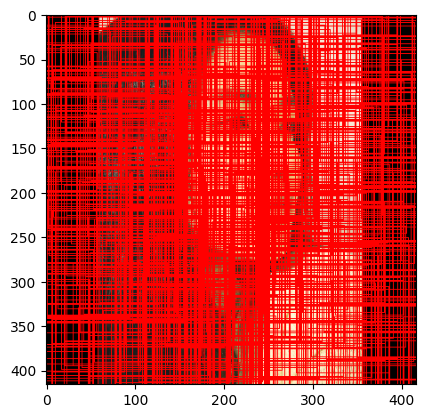

In [13]:
for g, anchor, stride in zip(out, anchors, STRIDES):
    i = (images[0].numpy()*255).astype(np.uint8)
    bbox = g[..., :4]
    conf = g[..., 4:5]
    prob = g[..., 5:]
    pred_xy = tf.sigmoid(bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride
    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), conf.numpy().reshape(-1, 1), prob.numpy().reshape(-1, 1)):
        if True or c>0.01:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)

    for a in anchor.numpy().reshape(-1, 4)*stride:
        p1 = (a[:2] - 0.5 * a[2:4]).astype(np.int32)
        p2 = (a[:2] + 0.5 * a[2:4]).astype(np.int32)
        # cv2.rectangle(i, p1, p2, (0, 255, 0), 1)


plt.imshow(i)
plt.show()

In [57]:
tf.reduce_all(tf.logical_and(pred_bbox[..., :2]>150, pred_bbox[..., :2]<350))

<tf.Tensor: shape=(), dtype=bool, numpy=False>